#Modelo estadistico de la Elasticidad Precio de la Demanda

In [18]:
from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

%matplotlib inline

In [3]:
beef = pd.read_csv('/content/drive/MyDrive/Data Kaggle/beef.csv')
beef.head()

,Year,Quarter,Quantity,Price
0,1977,1,22.9976,142.1667
1,1977,2,22.6131,143.9333
2,1977,3,23.4054,146.5000
3,1977,4,22.7401,150.8000
4,1978,1,22.0441,160.0000


In [25]:
beef.describe()

,Quantity,Price
count,91.000000,91.000000
mean,18.403309,250.440293
std,1.813343,37.010231
min,15.891500,142.166700
25%,17.043950,231.333350
50%,18.167800,250.100000
75%,19.358650,280.716700
max,23.405400,300.400000


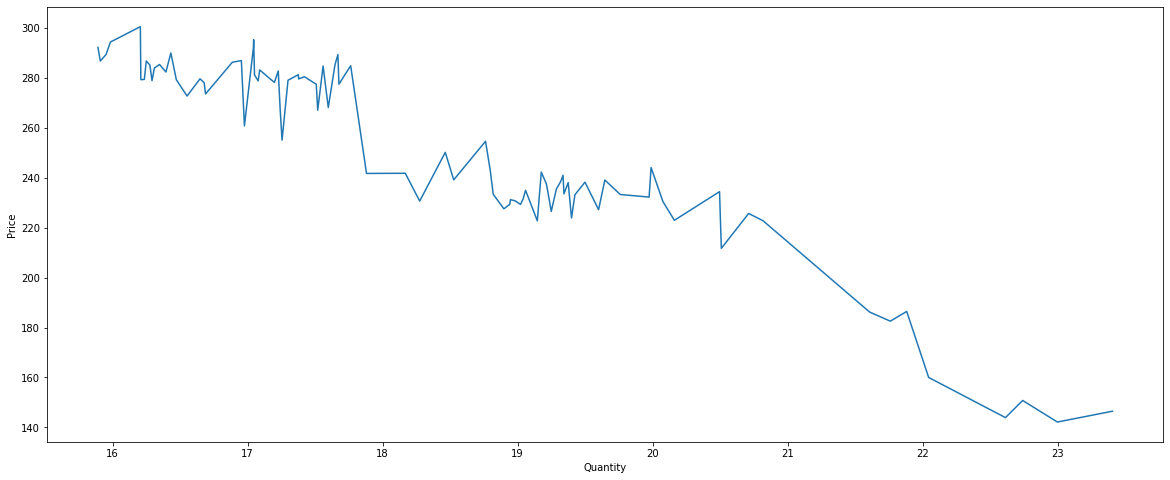

In [32]:
plt.figure(figsize=(20,8))
sns.lineplot(data=beef, x="Quantity", y="Price")

##Analisis de la Regresión

In [4]:
beef_model = ols("Quantity ~ Price", data=beef).fit()
print(beef_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     811.2
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           1.69e-46
Time:                        00:11:05   Log-Likelihood:                -77.493
No. Observations:                  91   AIC:                             159.0
Df Residuals:                      89   BIC:                             164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0515      0.413     72.701      0.0

Dado el bajo P-Value (0), podemos recharzar la hipotesis nula de que el precio no tiene efecto sobre la cantidad.
Un R cuadrado alto indica que nuestro modelo explica en gran parte la variablidad de la demanda.


t: es igual a t-stats, que indica la importancia de los hallazgos. Cuanto más cerca esté de 0, es más probable que no haya significado. Cuanto mayores sean las estadísticas t, ya sean positivas o negativas, mayor será la importancia de los hallazgos.

Pendiente (coeficiente): es la relación entre el "cambio de precio" y el "cambio de cantidad vendida" entre (cualquiera) dos puntos distintos en una línea

#Evaluación del modelo

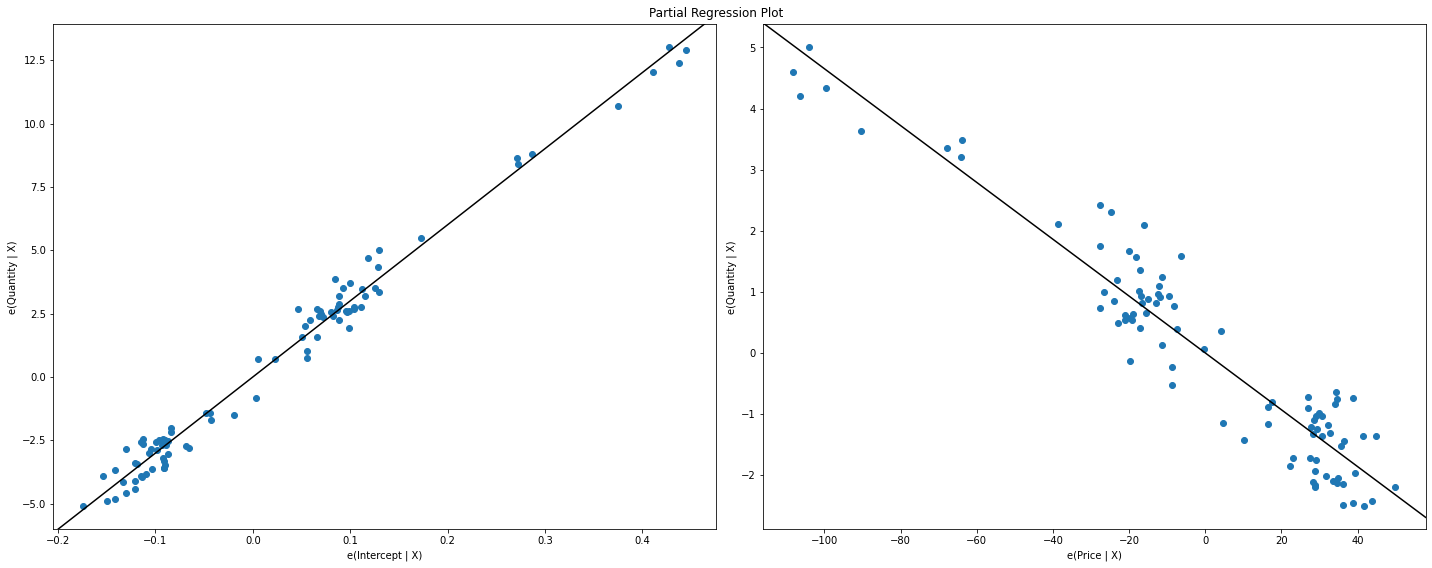

In [6]:
fig = plt.figure(figsize=(20,8))
fig = sm.graphics.plot_partregress_grid(beef_model, fig=fig)

La tendencia indica que el predictor (Price), provee informacion sobre la respuesta (Quantity) y los data points no caen lejos de la linea de regresión, por lo que la predicción es bien precisa.

##Componente-componente mas residual (CCPR)

El CCPR provee una manera de juzgar el efecto de un regresor sobre la variable dependiente o de respuesta, tomando en consideración los efectos de las otras variables independientes.

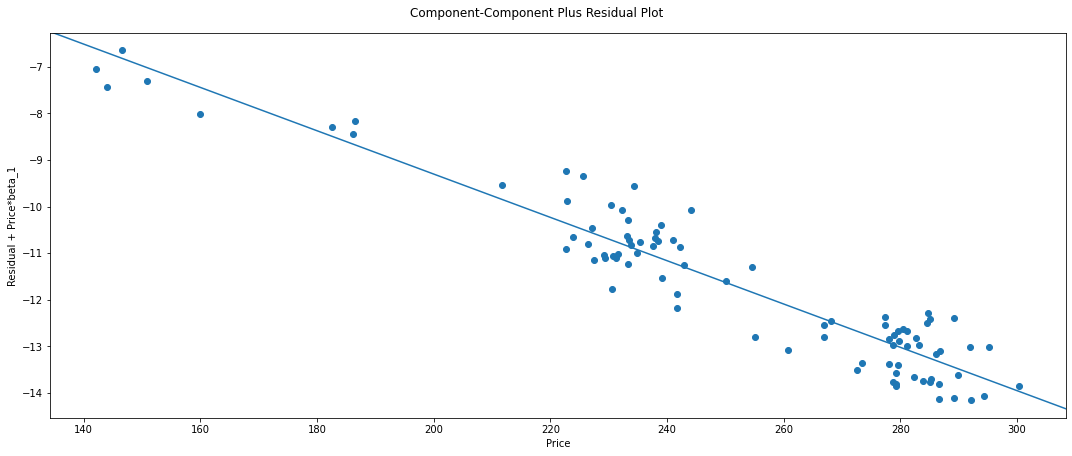

In [8]:
fig = plt.figure(figsize=(15, 12))
fig = sm.graphics.plot_ccpr_grid(beef_model, fig=fig)

CCPR permite ver que la relación entre la variable Quantity explicada por Price es definitivamente lineal. 

##Graficos de Regresión

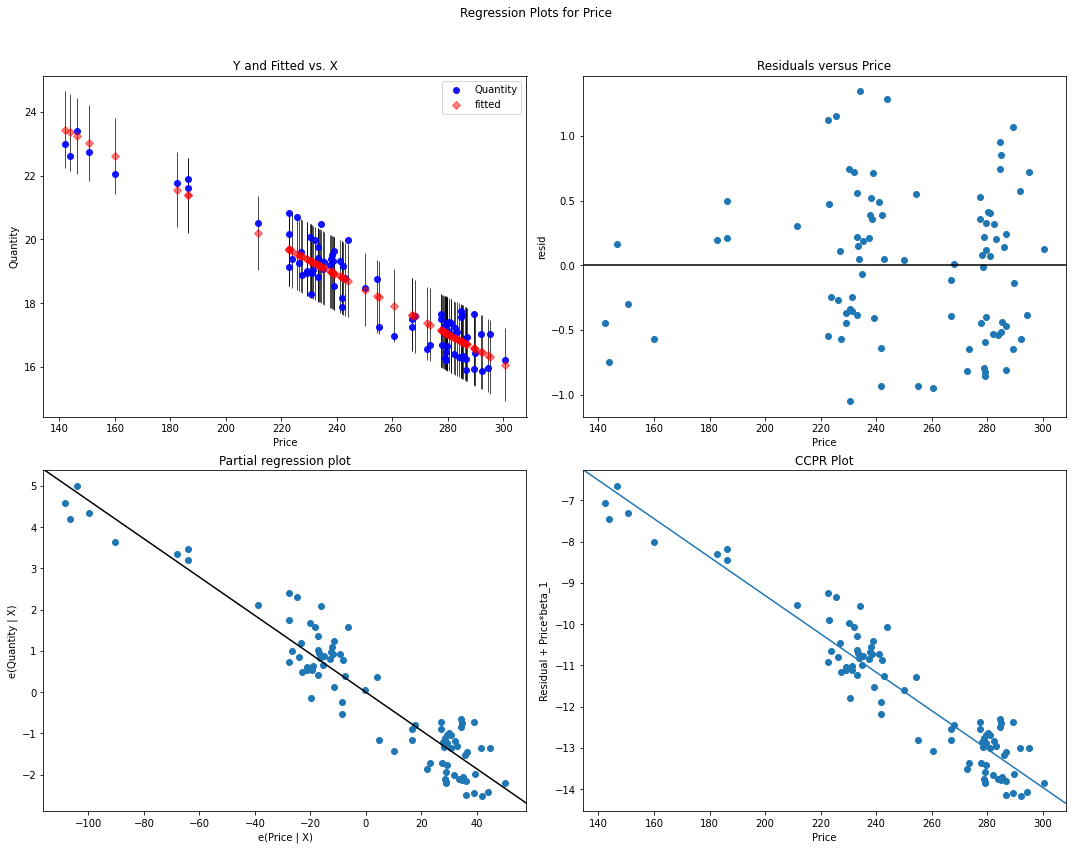

In [10]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(beef_model, 'Price', fig=fig)

##Mínimo cuadrado recursivo (RLS)

Aplicamos el filtro de mínimos cuadrados recursivos (RLS) para investigar la inestabilidad de los parámetros.
Antes de la estimación de RLS, manipularemos los datos y crearemos un índice de fecha y hora.

In [11]:
beef['Year'] = pd.to_datetime(beef['Year'], format="%Y")
from pandas.tseries.offsets import *
beef['Date'] = beef.apply(lambda x:(x['Year'] + BQuarterBegin(x['Quarter'])), axis=1)
beef.drop(['Year', 'Quarter'], axis=1, inplace=True)
beef.set_index('Date', inplace=True)
beef.head(10)

,Quantity,Price
Date,,
1977-03-01,22.9976,142.1667
1977-06-01,22.6131,143.9333
1977-09-01,23.4054,146.5000
1977-12-01,22.7401,150.8000
1978-03-01,22.0441,160.0000
1978-06-01,21.7602,182.5333
1978-09-01,21.6064,186.2000
1978-12-01,21.8814,186.4333
1979-03-01,20.5086,211.7000


##Estimación RLS


In [12]:
endog = beef['Quantity']
exog = sm.add_constant(beef['Price'])
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               Quantity   No. Observations:                   91
Model:                    RecursiveLS   Log Likelihood                 -86.733
Date:                Sat, 26 Jun 2021   R-squared:                       0.901
Time:                        00:35:26   AIC                            177.467
Sample:                    03-01-1977   BIC                            182.488
                         - 09-01-1999   HQIC                           179.493
Covariance Type:            nonrobust   Scale                            0.329
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0515      0.413     72.701      0.000      29.241      30.862
Price         -0.0465      0.002    -28.482      0.000      -0.050      -0.043
Ljung-Box (Q):                      422.30   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency BQS-DEC will be used.
  % freq, ValueWarning)


El modelo RLS calcula los parámetros de regresión de forma recursiva, por lo que hay tantas estimaciones como puntos de datos, la tabla de resumen solo presenta los parámetros de regresión estimados en toda la muestra; estas estimaciones son equivalentes a las estimaciones de OLS.

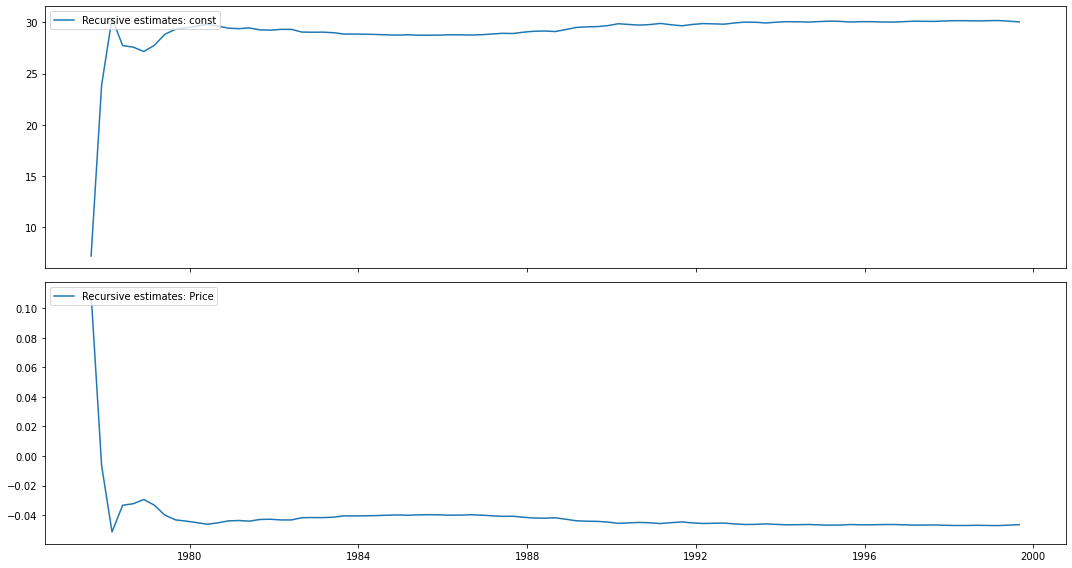

In [14]:
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(15,8));

##Grafico de Sumas Acumuladas (CUSUM)

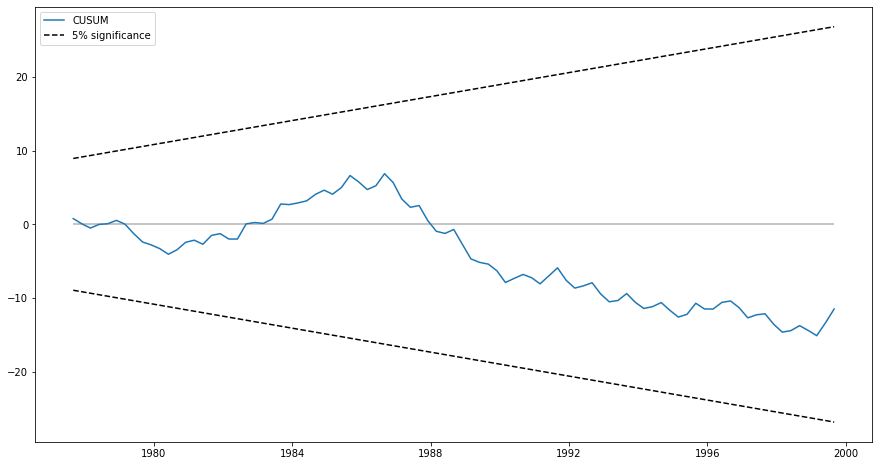

In [16]:
fig = res.plot_cusum(figsize=(15,8));

En el gráfico anterior, el estadístico CUSUM (acumulación de desviaciones de cada observación respecto a su valor objetivo) no se mueve fuera de las bandas de significancia del 5%, por lo que no rechazamos la hipótesis nula de parámetros estables al nivel del 5%.

##Como obtenemos la Elasticidad

PED o elasticidad de la demanda: porcentaje de cambio de la demanda/porcentaje del cambio de precio

PED en regresión lineal: coeficiente(pendiente o slope) * media de precio/media de demanda

In [27]:
### con el coeficiente -0.0465* media de Price/ Media de Quantity

coefficient = -0.0465

Price_mean = beef.Price.mean()

Quantity_mean = beef.Quantity.mean()

In [31]:
PED_regresion = coefficient * Price_mean / Quantity_mean
print(f'La Elasticidad Precio de la Demanda es: {PED_regresion}')

La Elasticidad Precio de la Demanda es: -0.6327923839961652


#Conclusiones
Elasticidades entre -1 y 1 se consideran Inelasticas.
Elasticidades menores a -1 se considera Elasticidad Negativa
Elasticidades mayores a 1 se Elasticidad Positiva

Por lo tanto, según nuestros resultados, al tener una elasticidad de -0.63, estos tienen una Elasticidad Negativa, lo cual quiere decir que, si nuestro producto bajara su precio en 10%, la demanda incrementaría 6,3%. En cambio, si nuestros precios se incrementan en 10%, nuestra demanda caería en 6,3%.
